In [219]:
# Step 1: Read the stored variables
%store -r df
%store -r EA_df
%store -r X_1
%store -r EA_vol_df_garch
%store -r EA_vol_df_std
%store -r EA_10Y_mth_yields
%store -r HICP__
%store -r GDP__

# Step 2: Import necessary libraries
import numpy as np
import pandas as pd
from pykalman import KalmanFilter
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import scipy.stats as ss
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints

# Step 3: Extract the relevant code after the 'Just Try' UKF implementation
# Assuming 'Just Try' UKF implementation starts from a specific cell, we will include the relevant code here

# Example of relevant code (replace with actual code after 'Just Try' UKF implementation)
data = df
EA_data = data['EA_10Y']

N = 12 * 24  # time steps
paths = 10  # number of paths
dt = 1/12

kappa = .5
theta = .5
sigma = .5

X0 = EA_data[0]
X = np.zeros((N, paths))
X[0, :] = X0
W = ss.norm.rvs(loc=0, scale=np.sqrt(dt), size=(N - 1, paths))

for t in range(0, N - 1):
    X[t + 1, :] = np.abs(X[t, :] + kappa * (theta - X[t, :]) * dt + sigma * W[t, :])

X_T = X[-1, :]  # values of X at time T
X_1 = X[:, 0]  # a single path
# plt.plot(X_1)
# plt.show()

EA_data_match = EA_data[0:len(X_1)]
# plt.plot(EA_data_match)
# plt.show()

EA_df_ = pd.DataFrame(EA_data_match)
EA_df_.index.name=None

EA_vol_df_garch = EA_vol_df_garch[0:len(X_1)]
EA_vol_df_garch.set_index('Date', inplace=True)
EA_vol_df_garch.index = pd.to_datetime(EA_vol_df_garch.index)

EA_vol_df_std = EA_vol_df_std[0:len(X_1)]
EA_vol_df_std.set_index('Date', inplace=True)
EA_vol_df_std.index = pd.to_datetime(EA_vol_df_std.index)

yield_and_vols = pd.concat([EA_df_, EA_vol_df_garch], axis=1)
yield_and_vols

HICP = HICP__
GDP = GDP__

print(np.var(EA_data_match), np.cov(EA_data_match))

ds = np.array(X_1)

# Estimating the OU parameters
from ouparams import ouparams
mu, sigma, theta = ouparams.find(ds)
# print(mu, sigma, theta)

2.787172979998198 2.796884384109691


In [220]:
%store -r level
%store -r slope

In [221]:
def symmetric_log_transform(x):
    if x >= 0:
        return np.log(x + 1)
    else:
        return -np.log(-x + 1)

# Example usage on a numpy array of GDP growth values
gdp_growth = GDP.values/100
hicp_temp = HICP.values/100
hicp_growth = np.log(hicp_temp)
# Apply the symmetric log transformation
symmetric_log_values = np.array([symmetric_log_transform(x) for x in gdp_growth])

##print("Original Values:", gdp_growth)
#print("Symmetric Log Transformed Values:", symmetric_log_values)
# plt.plot(symmetric_log_values)
# plt.plot(np.log(GDP.values/100))

In [222]:
# Example datasets
dates_yields = pd.date_range(start="2000-01-31", end="2024-04-30", freq='M')
EA_10Y_mth_yields__ = pd.Series(EA_10Y_mth_yields/100, index=dates_yields)

dates_vol = pd.date_range(start="2000-01-31", end="2023-12-31", freq='M')
#EA_vol_std__ = pd.Series(EA_vol_df_garch['GARCH Volatility'].values, index=dates_vol)
EA_vol_std__ = pd.Series(EA_vol_df_garch['GARCH Volatility'].values, index=dates_vol)

dates_hicp = pd.date_range(start="1999-12-31", end="2025-03-31", freq='Q')
HICP__ = pd.Series(hicp_temp, index=dates_hicp)

dates_gdp = pd.date_range(start="1999-01-01", end="2024-06-30", freq='Q')
GDP__ = pd.Series(symmetric_log_values, index=dates_gdp)

level = pd.Series(level, index=dates_yields)
slope = pd.Series(slope, index=dates_yields)

# Convert quarterly data to monthly by forward filling
HICP_monthly = HICP__.resample('M').interpolate(method='linear')
GDP_monthly = GDP__.resample('M').interpolate(method='linear')

# Find the common date range
common_start = max(EA_10Y_mth_yields__.index[0], EA_vol_std__.index[0], HICP_monthly.index[0], GDP_monthly.index[0])
common_end = min(EA_10Y_mth_yields__.index[-1], EA_vol_std__.index[-1], HICP_monthly.index[-1], GDP_monthly.index[-1])

# Truncate datasets to the common date range
EA_10Y_mth_yields__ = EA_10Y_mth_yields__.loc[common_start:common_end]
EA_vol_std__ = EA_vol_std__.loc[common_start:common_end]
HICP_monthly = HICP_monthly.loc[common_start:common_end]
GDP_monthly = GDP_monthly.loc[common_start:common_end]

# Combine all observations into a single array
avg_vol = np.mean(EA_vol_std__)

level = level.loc[common_start:common_end]
slope = slope.loc[common_start:common_end]

#observations = np.column_stack((EA_10Y_mth_yields__.values, EA_vol_std__.values, HICP_monthly.values, GDP_monthly.values))
observations = np.column_stack((EA_vol_std__.values, level.values, slope.values, HICP_monthly.values, GDP_monthly.values))
# observations = np.column_stack((EA_vol_std__.values, level.values, slope.values, HICP_monthly.values, GDP_monthly.values, EA_10Y_mth_yields__.values))

# Initial parameters
K_init = np.array([
    [0.2445, 0, 0, 0, 0], 
    [0.0823, 0.1356, 0.0789, -0.1207, -0.0257], 
    [0.0378, -0.0090, 0.3177, -0.1012, -0.1533], 
    [-0.0019, 0.0542, 0.0988, 0.4265, 0.0427], 
    [0.0088, 0.0312, 0.1609, 0.0332, 0.6246]
])
Theta_init = np.array([0.0038, 0, 0, 0.0214, 0.0257])
Sigma_init = np.array([
    [0.0635, 0, 0, 0, 0], 
    [0, 0.2373, 0, 0, 0], 
    [0, 0, 0.1226, 0, 0], 
    [0, 0, 0, 0.0101, 0], 
    [0, 0, 0, 0, 0.0099]
])
delta_0_init = 0.0296
delta_1_init = np.array([0, 1, 1, 0, 0])
lambda_0_init = np.array([-0.0515, -0.0278, 0.0325, 0.0001, 0.0002])
lambda_1_init = np.array([
    [0, 0, 0, 0, 0],
    [-0.0211, -0.3618, 0.0947, 0.3590, 0.0425],
    [-0.0047, -0.0494, -0.1315, 0.8385, 1.1479],
    [-0.0026, -0.0098, -0.0050, -0.0018, -0.0037],
    [-0.0008, -0.0027, -0.0013, -0.0049, -0.0007]
])

K_tilde = K_init + Sigma_init @ lambda_1_init
Theta_tilde = np.linalg.inv(K_tilde) @ (K_init @ Theta_init - Sigma_init @ lambda_0_init)

# Define Sigma_M from Table 3
Sigma_M_init = np.array([
    [0.0019, 0],
    [0, 0.0061]
])

alpha = np.array([0, 0, 0, 1, 1])
beta = np.array([
    [1, 1, 1, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]
])
var_vol = np.var(EA_vol_std__)

In [223]:
import scipy
from scipy.integrate import solve_ivp
from scipy.linalg import cholesky

In [224]:
def ensure_positive_definite(matrix, jitter=1e-5):
    try:
        cholesky(matrix)
    except np.linalg.LinAlgError:
        matrix += np.eye(matrix.shape[0]) * jitter
        while True:
            try:
                cholesky(matrix)
                break
            except np.linalg.LinAlgError:
                matrix += np.eye(matrix.shape[0]) * jitter
                jitter *= 10  # Increase jitter exponentially if needed
    return matrix

In [225]:
np.std(EA_10Y_mth_yields__.values)

0.016694828480694847

In [226]:
from joblib import Parallel, delayed
import torch

In [227]:
# # Global list to store unique measurements
# unique_measurements = []
# unique_transitions = []

# State transition function
def state_transition_function(x, dt, K, Theta, Sigma):
    #print(f"State transition function called with x={x}")
    # Debugging: Print input parameters
    # print(f"Input state x: {x}")
    #print(f"Time step dt: {dt}")
    #print(f"Matrix K: {K}")
    #print(f"Vector Theta: {Theta}")
    #print(f"Matrix Sigma: {Sigma}")
    F = scipy.linalg.expm(-K * dt)
    # print(f"State transition matrix F: {F}")
    C = (np.eye(len(F)) - F) @ Theta
    # print(f"Constant term C: {C}")
    epsilon_t = np.array([
        Theta[i] * Sigma[i, i]**2 / (2 * K[i, i]) * ((1 - np.exp(-K[i, i] * dt))**2) +
        Sigma[i, i]**2 / K[i, i] * ((np.exp(-K[i, i] * dt) - np.exp(-2 * K[i, i] * dt))**2) * x[0]
        for i in range(3)
    ] + [
        Sigma[i, i]**2 / (2 * K[i, i]) * (1 - np.exp(-2 * K[i, i] * dt))
        for i in range(3, 5)
    ])
    # e_t = np.random.normal(0, np.abs(epsilon_t))
    # transition = C + F @ x + e_t
    #print("Transition: ", transition)

    trans_dist = np.random.normal(C + F @ x, np.abs(epsilon_t))
    # eqn = x + K @ (Theta - x)*dt + e_t
    # if trans_dist.tolist() not in unique_transitions:
    #     unique_transitions.append(trans_dist.tolist())
    # print(f"Noise term epsilon_t: {epsilon_t}")
    # print("Transition Distribution: ", trans_dist)

    
    #print("State Equation: ", eqn)
    return trans_dist

# Measurement function
def measurement_function(x, A_tau, B_tau, observations, A_M, B_M, Sigma):
    #print(f"B_TAU going into measurement: {B_tau[-1]}, A_TAU {A_tau[-1]}")
    nu_t = np.random.normal(0, np.abs(np.var(EA_10Y_mth_yields__.values)))
    error_vol = np.random.normal(0, np.var(EA_vol_std__.values))
    GDP_var, HICP_var = np.var(GDP_monthly.values), np.var(HICP_monthly.values)
    error_GDP, error_HICP = np.random.normal(0, np.abs(GDP_var)), np.random.normal(0, np.abs(HICP_var))

    l_err = np.random.normal(0, np.abs(np.var(level.values)))  # Ensure this is a scalar
    s_err = np.random.normal(0, np.abs(np.var(slope.values)))

    # Ensure A_tau and B_tau are numpy arrays
    A_tau = np.array(A_tau)
    B_tau = np.array(B_tau)
    
    # print(f"A_tau: {A_tau}, B_tau: {B_tau}")  # Debugging print
    # print(f"A_tau type: {type(A_tau)}, B_tau type: {type(B_tau)}")  # Debugging print

    a_tau_ = -A_tau / 10
    b_tau_ = B_tau / 10

    # # Debugging information
    # #print(f"Measurement function called with x={x} and nu_t={nu_t}")
    # #print(f"A_M={A_M}, B_M={B_M}")

    # # Yields: linked to level and slope
    # # part1 = a_tau_[-1] + b_tau_[-1, 1] * x[1] + b_tau_[-1, 2] * x[2] + nu_t
    yields = a_tau_[-1] + np.dot(b_tau_[-1], x) + nu_t
    # ---------------------------------------------------------------------
    # # Ensure all elements are scalars or have compatible shapes
    part2 = a_tau_[-1] + np.dot(b_tau_[-1], x) + l_err
    part3 = a_tau_[-1] + np.dot(b_tau_[-1], x) + s_err
    
    Xi_t = np.diag([x[0], x[0], x[0], 1, 1])
    middle = np.dot(Sigma, np.dot(Xi_t, Sigma))
    # #V_t_tau = np.dot(np.dot(b_tau_[-1], Sigma), np.dot(Xi_t, np.dot(Sigma.T, b_tau_[-1])))
    V_t_ = np.dot(b_tau_[-1], np.dot(middle, b_tau_[-1]))
    part1 = V_t_ + error_vol
    # #print("V_t_tau: ", V_t_tau, "V_t_: ", V_t_)
    # # print("part2", part2)
    
    part4 = A_M[0] + np.dot(B_M[0], x) + error_HICP
    part5 = A_M[1] + np.dot(B_M[1], x) + error_GDP
    # ---------------------------------------------------------------------

    # print(f"part1: {part1}")
    # print(f"part2: {part2}")
    # print(f"part3: {part3}")
    # print(f"part4: {part4}")
    # # Debugging shapes and types
    # print(f"Shapes: part1={part1.shape if hasattr(part1, 'shape') else 'scalar'}, "
    #       f"part2={part2.shape if hasattr(part2, 'shape') else 'scalar'}, "
    #       f"part3={part3.shape if hasattr(part3, 'shape') else 'scalar'}, "
    #       f"part4={part4.shape if hasattr(part4, 'shape') else 'scalar'}")
    
    # Ensure all parts are compatible for array construction
    measurement = np.array([part1, x[1] + l_err, x[2] + s_err, part4, part5, yields], dtype='float64')

    # if measurement.tolist() not in unique_measurements:
    #     unique_measurements.append(measurement.tolist())
    #print("Measurement: ", measurement)

    # Debugging prints to inspect each part
    # print(f"x[0] + error_vol: {x[0] + error_vol}, shape: {np.shape(x[0] + error_vol)}")
    # print(f"x[1] + l_err: {x[1] + l_err}, shape: {np.shape(x[1] + l_err)}")
    # print(f"x[2] + s_err: {x[2] + s_err}, shape: {np.shape(x[2] + s_err)}")
    # print(f"x[3] + error_HICP: {x[3] + error_HICP}, shape: {np.shape(x[3] + error_HICP)}")
    # print(f"x[4] + error_GDP: {x[4] + error_GDP}, shape: {np.shape(x[4] + error_GDP)}")

    # Ensure the return value is a 1D array of shape (5,)
    result = np.array([
        x[0] + error_vol,
        x[1] + l_err,
        x[2] + s_err,
        x[3] + error_HICP,
        x[4] + error_GDP
    ], dtype='float64')
    
    # Debugging print to confirm the shape of the final result
    #print(f"Final measurement array: {result}, shape: {result.shape}")
    
    return result
    #return measurement # Yields, Volatilities, GDP, HICP
    #return np.array([x[0] + nu_t, x[1] + error_vol, x[3] + error_GDP, x[4] + error_HICP])
    # return observations

# Define process noise covariance function
# Optimized Q Matrix Calculation
def Q_matrix_5D(x, dt, K, Theta, Sigma):
    Q_t = np.array([
        Theta[i] * Sigma[i, i]**2 / (2 * K[i, i]) * ((1 - np.exp(-K[i, i] * dt))**2) +
        Sigma[i, i]**2 / K[i, i] * ((np.exp(-K[i, i] * dt) - np.exp(-2 * K[i, i] * dt))**2) * x[0]
        for i in range(3)
    ] + [
        Sigma[i, i]**2 / (2 * K[i, i]) * (1 - np.exp(-2 * K[i, i] * dt))
        for i in range(3, 5)
    ])
    Q_matrix = np.diag(Q_t)
    jitter = 1e-5
    Q_matrix += np.eye(Q_matrix.shape[0]) * jitter
    return ensure_positive_definite(Q_matrix)

# Define ODE functions
def dA_dt(t, A, B, Theta_tilde, K_tilde, Sigma, alpha, delta_0):
    dA = -Theta_tilde.T @ K_tilde.T @ B + 0.5 * np.sum((Sigma.T @ B)**2 * alpha) - delta_0
    return dA

def dB_dt(t, B, K_tilde, Sigma, beta, delta_1):
    try:
        # Log input values
        # print(f"t: {t}")
        # print(f"B: {B}")
        # print(f"K_tilde: {K_tilde}")
        # print(f"Sigma: {Sigma}")
        # print(f"beta: {beta}")
        # print(f"delta_1: {delta_1}")

        # Calculate dB
        dB = -K_tilde.T @ B + 0.5 * np.sum((Sigma.T @ B)**2 * beta, axis=1) + delta_1

        # Log intermediate values
        #print(f"dB: {dB}")

        # Check for NaN or Inf values
        if np.any(np.isnan(dB)) or np.any(np.isinf(dB)):
            raise ValueError("NaN or Inf in dB calculation")
        return dB
    
    except FloatingPointError as e:
        print(f"FloatingPointError in dB_dt: {e}")
        return np.zeros_like(B)
    
    except ValueError as e:
        print(f"ValueError in dB_dt: {e}")
        return np.zeros_like(B)

# Solve ODEs for each maturity
def solve_odes(maturities, steps_per_year, K_tilde, Theta_tilde, Sigma, alpha, beta, delta_0, delta_1):
    A_tau, B_tau = [], []
    # Initial conditions for ODEs
    A0 = 0
    B0 = np.zeros(5)
    
    for tau in maturities:
        t_eval = np.linspace(0, tau, tau * steps_per_year)
        sol_B = solve_ivp(lambda t, B: dB_dt(t, B, K_tilde, Sigma, beta, delta_1), [0, tau], B0, t_eval=t_eval)
        sol_A = solve_ivp(lambda t, A: dA_dt(t, A, sol_B.y[:, -1], Theta_tilde, K_tilde, Sigma, alpha, delta_0), [0, tau], [A0], t_eval=t_eval)
        A_tau.append(sol_A.y[0][-1])
        B_tau.append(sol_B.y[:, -1])
        # Print shapes and intermediate results for debugging
        # print(f"tau: {tau}")
        # print(f"sol_A.y shape: {sol_A.y.shape}, sol_A.y: {sol_A.y}")
        # print(f"sol_B.y shape: {sol_B.y.shape}, sol_B.y: {sol_B.y}")
    A_tau = np.array(A_tau)
    B_tau = np.array(B_tau)
    # Print shapes of results
    # print(f"A_tau shape: {A_tau.shape}, A_tau: {A_tau}")
    # print(f"B_tau shape: {B_tau.shape}, B_tau: {B_tau}")
    #print(f"A_tau: {A_tau[-1]}")
    #print(f"B_tau: {B_tau[-1]}")
    return A_tau, B_tau

# Compute B_M(tau) and A_M(tau)
def compute_BM_AM(tau, K, Sigma_M, Theta):
    try:
        Gamma_M = np.array([
            [0, 0, 0, 1, 0],
            [0, 0, 0, 0, 1]
        ])
        iota = np.array([1, 1])
        exp_term = scipy.linalg.expm(-K * tau)
        I = np.eye(K.shape[0])
        BM_tau = Gamma_M @ np.linalg.inv(K) @ (I - exp_term)
        AM_tau = (-0.5 * Sigma_M @ Sigma_M.T @ iota * tau) + ((tau * Gamma_M - BM_tau) @ Theta)
        #print("A_M: ", AM_tau, "B_M: ", BM_tau)

        if np.any(np.isnan(AM_tau)) or np.any(np.isnan(BM_tau)):
            raise ValueError("NaN in AM_tau or BM_tau calculation")
        
        return np.array(AM_tau, dtype='float64'), np.array(BM_tau, dtype='float64')
    
    except np.linalg.LinAlgError as e:
        print(f"LinAlgError in compute_BM_AM: {e}")
        return np.zeros((2,), dtype='float64'), np.zeros((2, 5), dtype='float64')
    
    except ValueError as e:
        print(f"ValueError in compute_BM_AM: {e}")
        return np.zeros((2,), dtype='float64'), np.zeros((2, 5), dtype='float64')



# # Log-likelihood calculation with jitter for stability
# def run_ukf(observations, K, Theta, Sigma, delta_0, lambda_0, lambda_1, X0, P0, R, dt, A_tau, B_tau, A_M, B_M):
#     #print(f"B_TAU GOING INTO RUN UKF {B_tau}, A_TAU {A_tau}")
#     points = MerweScaledSigmaPoints(n=5, alpha=0.2, beta=1.5, kappa=1)
#     ukf = UKF(dim_x=5, dim_z=observations.shape[1], fx=lambda x, dt: state_transition_function(x, dt, K, Theta, Sigma),
#               hx=lambda x: measurement_function(x, A_tau, B_tau, observations, A_M, B_M, Sigma), dt=dt, points=points)
#     ukf.x = X0
#     jitter = 1e-6
#     ukf.P = ensure_positive_definite(P0 + np.eye(P0.shape[0]) * jitter)
#     ukf.R = ensure_positive_definite(R)
#     # ukf.Q = np.eye(5) * 0.001

#     # print(f"Initial P0: {ukf.P}")  # Debugging print

#     log_likelihood = 0
#     for idx, z in enumerate(observations):
#         Q = Q_matrix_5D(ukf.x, dt, K, Theta, Sigma)
#         ukf.Q = ensure_positive_definite(Q + np.eye(Q.shape[0]) * jitter)

#         # print(f"Q before jitter: {Q}")  # Debugging print
#         # print(f"Q after jitter: {ukf.Q}")  # Debugging print

#         #print(f"Observation {idx}: {z}")
#         ukf.predict()
#         try:
#             ukf.update(z)
#         except (np.linalg.LinAlgError, ValueError) as e:
#             print(f"Error during UKF update: {e}")
#             return np.inf
#         log_likelihood += ukf.log_likelihood
#         #S_stable = ukf.S + np.eye(ukf.S.shape[0]) * jitter
#         #print(f"Log likelihood at observation {idx}: {log_likelihood}")

#     return -log_likelihood

def run_ukf(observations, K, Theta, Sigma, delta_0, lambda_0, lambda_1, X0, P0, R, dt, A_tau, B_tau, A_M, B_M):
    points = MerweScaledSigmaPoints(n=5, alpha=0.2, beta=1.5, kappa=1)
    ukf = UKF(dim_x=5, dim_z=observations.shape[1], fx=lambda x, dt: state_transition_function(x, dt, K, Theta, Sigma),
              hx=lambda x: measurement_function(x, A_tau, B_tau, observations, A_M, B_M, Sigma), dt=dt, points=points)
    ukf.x = X0
    jitter = 1e-6
    ukf.P = ensure_positive_definite(P0 + np.eye(P0.shape[0]) * jitter)
    ukf.R = ensure_positive_definite(R)

    log_likelihood = 0
    N = observations.shape[1]  # Number of observations per time step
    for idx, z in enumerate(observations):
        Q = Q_matrix_5D(ukf.x, dt, K, Theta, Sigma)
        ukf.Q = ensure_positive_definite(Q + np.eye(Q.shape[0]) * jitter)

        ukf.predict()
        try:
            ukf.update(z)
        except (np.linalg.LinAlgError, ValueError) as e:
            print(f"Error during UKF update: {e}")
            return np.inf

        # Calculate the log-likelihood for the current time step
        innovation = z - ukf.hx(ukf.x)  # Measurement residual
        S_inv = np.linalg.inv(ukf.S)  # Inverse of the innovation covariance matrix
        term1 = N * np.log(2 * np.pi)
        term2 = np.log(np.linalg.det(ukf.S))
        term3 = innovation.T @ S_inv @ innovation
        log_likelihood += -0.5 * (term1 + term2 + term3)

    return -log_likelihood  # Return negative log-likelihood for minimization

def check_for_invalid_values(arr, name):
    if np.any(np.isnan(arr)) or np.any(np.isinf(arr)):
        print(f"Invalid values detected in {name}: {arr}")
        return True
    return False

# Objective function for optimization
def objective_function(params, observations, X0, P0, R, dt, maturities, steps_per_year):
    # print("Objective function called")
    K = params[:25].reshape((5, 5))
    #K[0,1], K[0,2], K[0,3], K[0,4] = 0, 0, 0, 0
    Theta = params[25:30]
    #Theta[1], Theta[2] = 0, 0
    Sigma = np.diag(params[30:35])
    delta_0 = params[35]
    lambda_0 = params[36:41]
    lambda_1 = params[41:66].reshape((5, 5))
    #lambda_1[0,0], lambda_1[0,1], lambda_1[0,2], lambda_1[0,3], lambda_1[0,4] = 0, 0, 0, 0, 0
    Sigma_M = np.diag(params[66:70])

    if check_for_invalid_values(K, "K") or check_for_invalid_values(Theta, "Theta") or check_for_invalid_values(Sigma, "Sigma"):
        return np.inf

    delta_1 = np.array([0, 1, 1, 0, 0])
        # Calculate Theta_tilde and K_tilde using the provided initial parameters
    K_tilde = K + Sigma @ lambda_1
    Theta_tilde = np.linalg.inv(K_tilde) @ (K @ Theta - Sigma @ lambda_0)

    if check_for_invalid_values(K_tilde, "K_tilde") or check_for_invalid_values(Theta_tilde, "Theta_tilde"):
        return np.inf
    
    alpha_ = np.array([0, 0, 0, 1, 1])
    beta_ = np.array([
        [1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]
    ])

    tau = 10

    A_tau, B_tau = solve_odes(maturities, steps_per_year, K_tilde, Theta_tilde, Sigma, alpha_, beta_, delta_0, delta_1)
    A_M_tau, B_M_tau = compute_BM_AM(maturities[tau-1], K, Sigma_M, Theta)
    #print(f"B_TAU IN OBJECTIVE {B_tau}, A_TAU {A_tau}")

    # Print shapes and values before passing to run_ukf
    # print("A_tau:", A_tau)
    # print("B_tau:", B_tau)
    # print("A_tau[tau-1]:", A_tau[tau-1])
    # print("B_tau[tau-1]:", B_tau[tau-1])
    # print("A_M_tau:", A_M_tau)
    # print("B_M_tau:", B_M_tau)
    if check_for_invalid_values(A_tau, "A_tau") or check_for_invalid_values(B_tau, "B_tau") or check_for_invalid_values(A_M_tau, "A_M_tau") or check_for_invalid_values(B_M_tau, "B_M_tau"):
        return np.inf
    # Check for NaNs or Infs
    # arrays_to_check = [K, Theta, Sigma, delta_0, lambda_0, lambda_1, Sigma_M, K_tilde, Theta_tilde, A_tau, B_tau, A_M_tau, B_M_tau]
    # for array in arrays_to_check:
    #     if np.any(np.isnan(array)) or np.any(np.isinf(array)):
    #         return np.inf
    
    regularization = np.sum(np.square(params)) * 1e-5
    return run_ukf(observations, K, Theta, Sigma, delta_0, lambda_0, lambda_1, X0, P0, R, dt, A_tau, B_tau, A_M_tau, B_M_tau) + regularization

# Parallelized version of the objective function
def parallel_objective(params_list, observations_cut, X0, P0, R, delta, maturities, steps_per_year):
    results = Parallel(n_jobs=-1)(
        delayed(objective_function)(params, observations_cut, X0, P0, R, delta, maturities, steps_per_year)
        for params in params_list
    )
    return results

In [228]:
def optimize_parameters():
    
    initial_level = 0.04026058316399593
    initial_slope = 0.0009014964873203385

    # Initial state and covariance
    X0 = np.array([EA_vol_std__.values[0], level.values[0],  slope.values[0], HICP_monthly.values[0], GDP_monthly.values[0]])

    initial_level_var = 0.0005480207963663772
    initial_slope_var = 0.000021097543572868867

    P0 = np.eye(5) * [np.var(EA_vol_std__.values), initial_level_var, initial_slope_var, np.var(HICP_monthly.values), np.var(GDP_monthly.values)]

    R = np.eye(5) * [np.var(EA_vol_std__.values), np.var(level.values), np.var(slope.values), np.var(HICP_monthly.values), np.var(GDP_monthly.values)]  # Adjusted to match observation dimensions  

    # P0 = np.eye(5) * [(Sigma_init[0,0]**2 * Theta_init[0] / 2) / K_init[0,0],
    #                   (Sigma_init[1,1]**2 * Theta_init[1] / 2) / K_init[1,1] + np.random.normal(0, abs((Sigma_init[1,1]**2 * (Theta_init[1] + 1e-7) / 2) / K_init[1,1])),
    #                   (Sigma_init[2,2]**2 * Theta_init[2] / 2) / K_init[2,2] + np.random.normal(0, abs((Sigma_init[2,2]**2 * (Theta_init[2] + 1e-7) / 2) / K_init[2,2])),
    #                   Sigma_init[3,3]**2 / (2 * K_init[3,3]), 
    #                   Sigma_init[4,4]**2 / (2 * K_init[4,4])] + np.eye(5) * 1e-5  # Add higher jitter to P0
    # print(f"FIRST P0: {P0}")

    # Q = np.eye(5) * [Sigma_init[0][0]**2 / (2 * K_init[0][0]) * (1 - np.exp(-2 * K_init[0][0] * dt)),
    #                  Sigma_init[1][1]**2 / (2 * K_init[1][1]) * (1 - np.exp(-2 * K_init[1][1] * dt)),
    #                  Sigma_init[2][2]**2 / (2 * K_init[2][2]) * (1 - np.exp(-2 * K_init[2][2] * dt)),
    #                  Sigma_init[-2][-2]**2 / (2 * K_init[-2][-2]) * (1 - np.exp(-2 * K_init[-2][-2] * dt)), 
    #                  Sigma_init[-1][-1]**2 / (2 * K_init[-1][-1]) * (1 - np.exp(-2 * K_init[-1][-1]* dt))]

    # R = np.eye(4) * [np.var(EA_10Y_mth_yields__.values), np.var(EA_vol_std__.values), np.var(HICP_monthly.values), np.var(GDP_monthly.values)]  # Adjusted to match observation dimensions

    # Perturb initial parameters slightly for optimization
    initial_params = np.hstack([
        K_init.flatten() + np.random.normal(0, 0.1, K_init.flatten().shape),
        Theta_init + np.random.normal(0, 0.1, Theta_init.shape),
        np.diag(Sigma_init) + np.random.normal(0, 0.1, np.diag(Sigma_init).shape),
        delta_0_init + np.random.normal(0, 0.1, 1),
        lambda_0_init + np.random.normal(0, 0.1, lambda_0_init.shape),
        lambda_1_init.flatten() + np.random.normal(0, 0.3, lambda_1_init.flatten().shape),
        np.diag(Sigma_M_init) + np.random.normal(0, 0.001, np.diag(Sigma_M_init).shape)
    ])

    observations_cut = observations

    # Define maturities and steps per year
    maturities = np.arange(1, 11)  # Example maturities from 1 to 10 years
    steps_per_year = 12  # Monthly steps
    
    # Use torch for GPU acceleration if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    initial_params_torch = torch.tensor(initial_params, device=device, requires_grad=True).to(device)

    # Define the objective function for PyTorch
    def objective_function_torch(params):
        params_np = params.detach().cpu().numpy()
        loss = objective_function(params_np, observations_cut, X0, P0, R, 1/12, maturities, steps_per_year)
        return torch.tensor(loss, device=device, dtype=torch.float32, requires_grad=True)

    # Define the constraints projection function
    def project_params(params):
        params_np = params.detach().cpu().numpy()
        K = params_np[:25].reshape((5, 5))
        Theta = params_np[25:30]
        lambda_1 = params_np[41:66].reshape((5, 5))

        # Enforce constraints
        K[0, 1:] = 0  # Diagonal elements of the first row of K must be zero
        Theta[1] = 0  # Second element of Theta must be zero
        Theta[2] = 0  # Third element of Theta must be zero
        lambda_1[0, :] = 0  # First row of lambda_1 must be zero

        # Reconstruct the parameter array
        params_np[:25] = K.flatten()
        params_np[25:30] = Theta
        params_np[41:66] = lambda_1.flatten()

        # Convert back to torch tensor
        params.data = torch.tensor(params_np, device=device, requires_grad=True)
        return params

    # Use PyTorch's LBFGS optimizer
    optimizer = torch.optim.LBFGS([initial_params_torch], lr=0.1)

    def closure():
        optimizer.zero_grad()
        loss = objective_function_torch(initial_params_torch)
        loss.backward()
        return loss

    # optimizer.step(closure)

    for _ in range(100):  # Run optimization for a fixed number of steps
        optimizer.step(closure)
        initial_params_torch = project_params(initial_params_torch)  # Apply constraints after each step

    # Optimize parameters
    # result = minimize(objective_function, initial_params_torch, args=(observations_cut, X0, P0, R, 1/12, maturities, steps_per_year), method='L-BFGS-B')
    
    # Use 'SLSQP' method for optimization with constraints
    # result = minimize(
    #     objective_function, initial_params, 
    #     args=(observations_cut, X0, P0, R, 1/12, maturities, steps_per_year),
    #     method='SLSQP', constraints={'type': 'eq', 'fun': constraint_eq},
    #     options={'disp': True, 'maxiter': 500}
    # )

    # Extract estimated parameters
    estimated_params = initial_params_torch.detach().cpu().numpy()
    print("Size of estimated_params:", estimated_params.size)  # Debugging line
    # Extract estimated parameters
    # estimated_params = result.x
    K_estimated = estimated_params[:25].reshape((5, 5))
    Theta_estimated = estimated_params[25:30]
    Sigma_estimated = np.diag(estimated_params[30:35])
    delta_0_estimated = estimated_params[35]
    lambda_0_estimated = estimated_params[36:41]
    lambda_1_estimated = estimated_params[41:66].reshape((5, 5))
    Sigma_M_estimated = np.diag(estimated_params[66:70])

    print("Estimated K:", K_estimated)
    print("Estimated Theta:", Theta_estimated)
    print("Estimated Sigma:", Sigma_estimated)
    print("Estimated delta_0:", delta_0_estimated)
    print("Estimated lambda_0:", lambda_0_estimated)
    print("Estimated lambda_1:", lambda_1_estimated)
    print("Estimated Sigma_M:", Sigma_M_estimated)

    return K_estimated, Theta_estimated, Sigma_estimated, delta_0_estimated, lambda_0_estimated, lambda_1_estimated, Sigma_M_estimated

In [229]:
K_estimated, Theta_estimated, Sigma_estimated, delta_0_estimated, lambda_0_estimated, lambda_1_estimated, Sigma_M_estimated = optimize_parameters()

KeyboardInterrupt: 

In [230]:
# Number of times to run the optimization
num_runs = 100

# Initialize arrays to store the results
K_results = np.zeros((num_runs, 5, 5))
Theta_results = np.zeros((num_runs, 5))
Sigma_results = np.zeros((num_runs, 5))
delta_0_results = np.zeros(num_runs)
lambda_0_results = np.zeros((num_runs, 5))
lambda_1_results = np.zeros((num_runs, 5, 5))
Sigma_M_results = np.zeros((num_runs, 2))

# Run the optimization multiple times
for i in range(num_runs):
    K_estimated, Theta_estimated, Sigma_estimated, delta_0_estimated, lambda_0_estimated, lambda_1_estimated, Sigma_M_estimated = optimize_parameters()
    K_results[i] = K_estimated
    Theta_results[i] = Theta_estimated
    Sigma_results[i] = np.diag(Sigma_estimated)
    delta_0_results[i] = delta_0_estimated
    lambda_0_results[i] = lambda_0_estimated
    lambda_1_results[i] = lambda_1_estimated
    Sigma_M_results[i] = np.diag(Sigma_M_estimated)


# Calculate and print statistics
print("K_estimated: mean =", np.mean(K_results, axis=0), ", std =", np.std(K_results, axis=0))
print("Theta_estimated: mean =", np.mean(Theta_results, axis=0), ", std =", np.std(Theta_results, axis=0))
print("Sigma_estimated: mean =", np.mean(Sigma_results, axis=0), ", std =", np.std(Sigma_results, axis=0))
print("delta_0_estimated: mean =", np.mean(delta_0_results), ", std =", np.std(delta_0_results))
print("lambda_0_estimated: mean =", np.mean(lambda_0_results, axis=0), ", std =", np.std(lambda_0_results, axis=0))
print("lambda_1_estimated: mean =", np.mean(lambda_1_results, axis=0), ", std =", np.std(lambda_1_results, axis=0))
print("Sigma_M_estimated: mean =", np.mean(Sigma_M_results, axis=0), ", std =", np.std(Sigma_M_results, axis=0))

Size of estimated_params: 68
Estimated K: [[ 0.20950354  0.          0.          0.          0.        ]
 [ 0.15510636  0.17963525  0.27100623 -0.23124955  0.17824076]
 [-0.00620234  0.08266893  0.18213141 -0.23790954 -0.28623237]
 [-0.11221207  0.08656978  0.05370062  0.51808164  0.16098541]
 [-0.10082767  0.02095288  0.23398725 -0.12155344  0.66257707]]
Estimated Theta: [-0.18002444  0.          0.          0.05196435 -0.06150445]
Estimated Sigma: [[-0.03392503  0.          0.          0.          0.        ]
 [ 0.          0.3039172   0.          0.          0.        ]
 [ 0.          0.          0.16940238  0.          0.        ]
 [ 0.          0.          0.         -0.1038082   0.        ]
 [ 0.          0.          0.          0.          0.13707128]]
Estimated delta_0: -0.049049599388288956
Estimated lambda_0: [ 0.14646133 -0.08923752  0.06022554 -0.19953936 -0.07732005]
Estimated lambda_1: [[ 0.          0.          0.          0.          0.        ]
 [ 0.21422177 -0.6140905

In [231]:
K_estimated_mean, K_std = np.mean(K_results, axis=0), np.std(K_results, axis=0)
Theta_estimated_mean, Theta_std = np.mean(Theta_results, axis=0), np.std(Theta_results, axis=0)
Sigma_estimated_mean, Sigma_std = np.mean(Sigma_results, axis=0), np.std(Sigma_results, axis=0)
delta_0_estimated_mean, delta_0_std = np.mean(delta_0_results), np.std(delta_0_results)
lambda_0_estimated_mean, lambda_0_std = np.mean(lambda_0_results, axis=0), np.std(lambda_0_results, axis=0)
lambda_1_estimated_mean, lambda_1_std = np.mean(lambda_1_results, axis=0), np.std(lambda_1_results, axis=0)
Sigma_M_estimated_mean, Sigma_M_std = np.mean(Sigma_M_results, axis=0), np.std(Sigma_M_results, axis=0)

In [167]:
%store -r K_estimated_mean
%store -r Theta_estimated_mean
%store -r Sigma_estimated_mean
%store -r delta_0_estimated_mean
%store -r lambda_0_estimated_mean
%store -r lambda_1_estimated_mean
%store -r Sigma_M_estimated_mean

In [168]:
K_estimated_constraint = K_estimated_mean
#K_estimated_constraint[0,1], K_estimated_constraint[0,2], K_estimated_constraint[0,3], K_estimated_constraint[0,4] = 0, 0, 0, 0
Theta_estimated_constraint = Theta_estimated_mean
#Theta_estimated_constraint[1], Theta_estimated_constraint[2] = 0, 0
lambda_1_estimated_constraint = lambda_1_estimated_mean
#lambda_1_estimated_constraint[0,0], lambda_1_estimated_constraint[0,1], lambda_1_estimated_constraint[0,2], lambda_1_estimated_constraint[0,3], lambda_1_estimated_constraint[0,4] = 0, 0, 0, 0, 0

# print("Estimated K:", K_estimated_constraint)
# print("Estimated Theta:", Theta_estimated_constraint)
# print("Estimated lambda_1:", lambda_1_estimated_constraint)

In [169]:
Sigma_estimated_mean = np.diag(Sigma_estimated_mean)
Sigma_M_estimated_mean = np.diag(Sigma_M_estimated_mean)

In [170]:
tau = 10

Volatility - MSE: 4.132371417255622e-09, RMSE: 6.428352368418848e-05
Level - MSE: 4.8267418278774874e-05, RMSE: 0.006947475676731432
Slope - MSE: 4.896032505581893e-07, RMSE: 0.000699716550153124
Inflation - MSE: 7.242958051637913e-07, RMSE: 0.0008510557003885182
GDP Growth - MSE: 1.1125518032354093e-05, RMSE: 0.003335493671460657


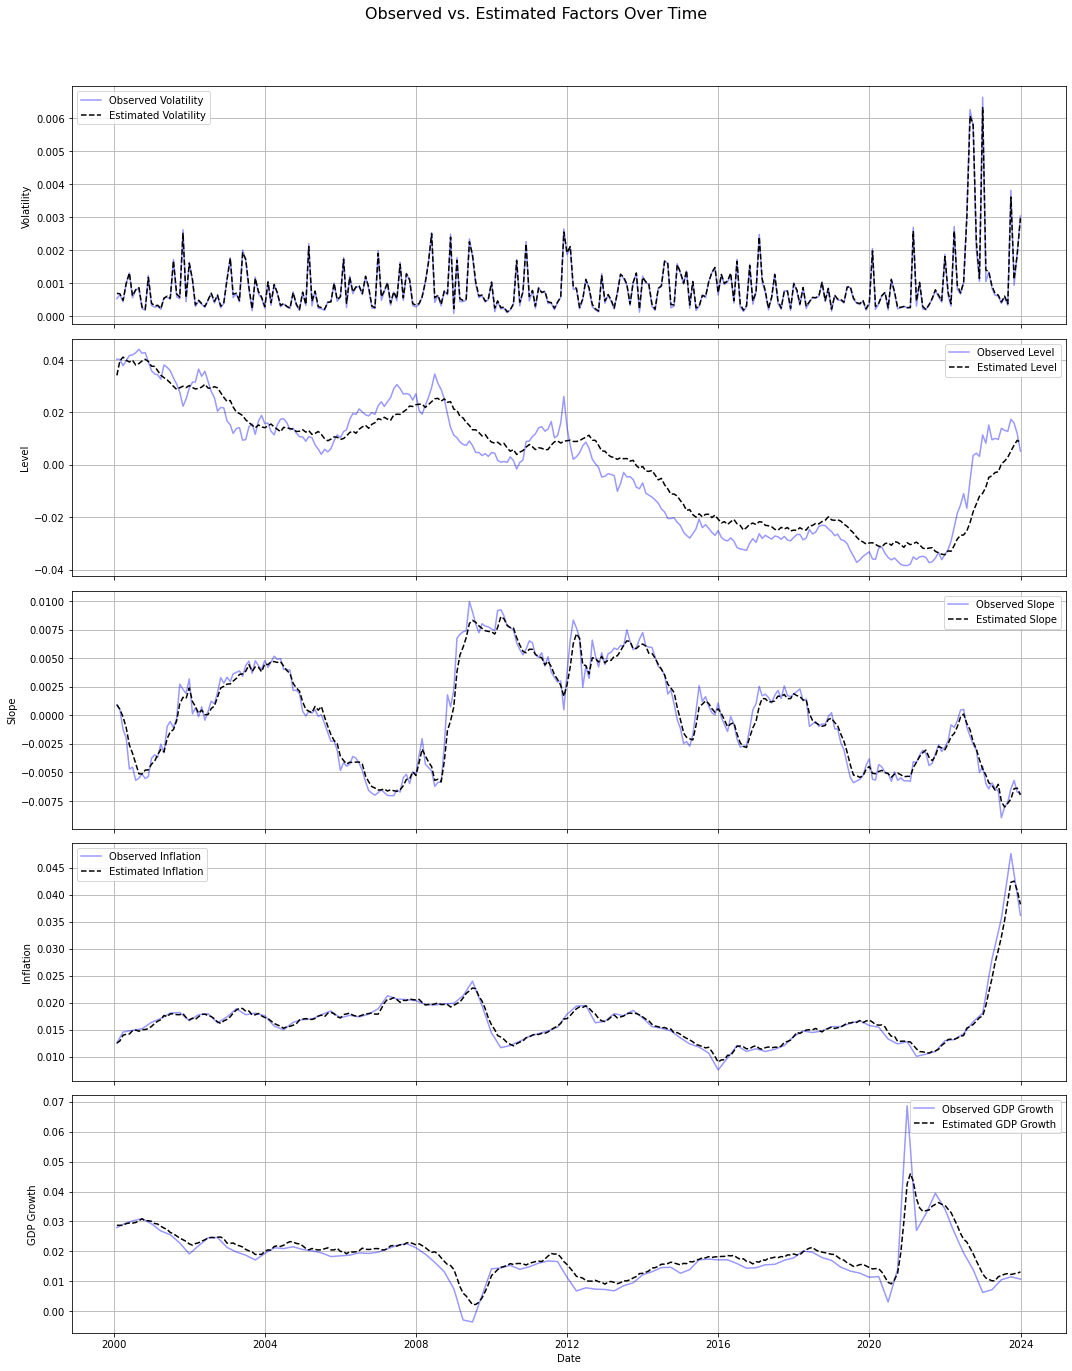

In [218]:
observations_cut = observations

# Define maturities and steps per year
maturities = np.arange(1, 11)  # Example maturities from 1 to 10 years
steps_per_year = 12  # Monthly steps

K_tilde_estimated = K_estimated_constraint + Sigma_estimated_mean @ lambda_1_estimated_constraint
Theta_tilde_estimated = np.linalg.inv(K_tilde_estimated) @ (K_estimated_constraint @ Theta_estimated_constraint - Sigma_estimated_mean @ lambda_0_estimated_mean)

A_tau_estimated, B_tau_estimated = solve_odes(maturities, steps_per_year, K_tilde_estimated, Theta_tilde_estimated, Sigma_estimated_mean, alpha, beta, delta_0_estimated_mean, delta_1_init)
A_M_estimated, B_M_estimated = compute_BM_AM(maturities[tau-1], K_estimated_constraint, Sigma_M_estimated_mean, Theta_estimated_constraint)

points = MerweScaledSigmaPoints(n=5, alpha=0.2, beta=1.5, kappa=1)
ukf = UKF(dim_x=5, dim_z=observations_cut.shape[1], fx=lambda x, dt: state_transition_function(x, dt, K_estimated_constraint, Theta_estimated_constraint, Sigma_estimated_mean),
            hx=lambda x: measurement_function(x, A_tau_estimated, B_tau_estimated, observations_cut, A_M_estimated, B_M_estimated, Sigma_estimated_mean), dt=dt, points=points)

# initial_level = 0.04
# initial_slope = 0.001
init_pi = GDP_monthly.values[0]
init_mu = HICP_monthly.values[0]

# Initial state and covariance
X0 = np.array([EA_vol_std__.values[0], level.values[0],  slope.values[0], init_mu, init_pi])

# initial_level_var = 0.0005480207963663772
# initial_slope_var = 2.1097543572868867e-05

P0 = np.eye(5) * [np.var(EA_vol_std__.values), np.var(level.values), np.var(slope.values), np.var(HICP_monthly.values), np.var(GDP_monthly.values)]

# 4
#R = np.eye(observations_cut.shape[1]) * [np.var(EA_10Y_mth_yields__.values), np.var(EA_vol_std__.values), np.var(HICP_monthly.values), np.var(GDP_monthly.values)]  # Adjusted to match observation dimensions
# 5 
R = np.eye(observations_cut.shape[1]) * [np.var(EA_vol_std__.values), np.var(level.values), np.var(slope.values), np.var(HICP_monthly.values), np.var(GDP_monthly.values)]  # Adjusted to match observation dimensions
# 6
#R = np.eye(observations_cut.shape[1]) * [np.var(EA_vol_std__.values), np.var(level.values), np.var(slope.values), np.var(HICP_monthly.values), np.var(GDP_monthly.values), np.var(EA_10Y_mth_yields__.values)]  # Adjusted to match observation dimensions  
#R = np.eye(observations_cut.shape[1]) * .00001  # Adjusted to match observation dimensions

ukf.x = X0
ukf.P = P0
ukf.R = R
#ukf.Q = np.eye(5) * 0.0001
# print(f"Initial P0: {ukf.P}")  # Debugging print

estimated_states = []
# print("Initial State:", ukf.x)

for z in observations:
    #print(f"Current Observation: {z}")  # Debugging print
    Q = Q_matrix_5D(ukf.x, dt, K_estimated_constraint, Theta_estimated_constraint, Sigma_estimated_mean)
    ukf.Q = ensure_positive_definite(Q)
    
    # Predict step
    ukf.predict()
    #print(f"Predicted state before update: {ukf.x}")  # Debugging print
    
    try:
        # Update step
        ukf.update(z)
        #print(f"Updated state: {ukf.x}")  # Debugging print
    except np.linalg.LinAlgError as e:
        print(f"LinAlgError during UKF update: {e}")
        print(f"Covariance matrix P: {ukf.P}")
    except ValueError as e:
        print(f"ValueError during UKF update: {e}")
        print(f"Observation: {z}")
        print(f"Observation shape: {z.shape}")
    
    estimated_states.append(ukf.x)

estimated_states = np.array(estimated_states)

# Ensure the dates array matches the length of the observations
dates_yields_truncated = dates_yields[:observations_cut.shape[0]]

# plt.figure(figsize=(15, 10))
# obplt = plt.plot(dates_yields_truncated, observations_cut, alpha=0.5, label=f'Observed')
# esplt = plt.plot(dates_yields_truncated, estimated_states, '--', label=f'Estimated Proxy')
# #plt.legend()
# #plt.legend(iter(obplt), ('Observed yield', 'Observed v', 'Observed pi', 'Observed mu'))
# plt.legend(iter(esplt), ('Estimated Proxy v', 'Estimated Proxy l', 'Estimated Proxy s', 'Estimated Proxy pi', 'Estimated Proxy mu'))

# Define the factor names for labeling
factors = ['Volatility', 'Level', 'Slope', 'Inflation', 'GDP Growth']

# Create subplots for each factor
fig, axes = plt.subplots(len(factors), 1, figsize=(15, 20), sharex=True)

for i, factor in enumerate(factors):
    axes[i].plot(dates_yields_truncated, observations_cut[:, i], color="b", label=f'Observed {factor}', alpha=0.4)
    axes[i].plot(dates_yields_truncated, estimated_states[:, i], color='black', ls='--', alpha=1, label=f'Estimated {factor}')
    axes[i].set_ylabel(factor)
    axes[i].legend()
    axes[i].grid(True)

# # Calculate error metrics
# mse = np.mean((estimated_states[:, :] - observations) ** 2, axis=0)
# rmse = np.sqrt(mse)
# print(f'MSE: {mse}')
# print(f'RMSE: {rmse}')

axes[-1].set_xlabel('Date')
plt.suptitle('Observed vs. Estimated Factors Over Time', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Calculate error metrics
mse = np.mean((estimated_states - observations) ** 2, axis=0)
rmse = np.sqrt(mse)
for idx, factor in enumerate(factors):
    print(f'{factor} - MSE: {mse[idx]}, RMSE: {rmse[idx]}')

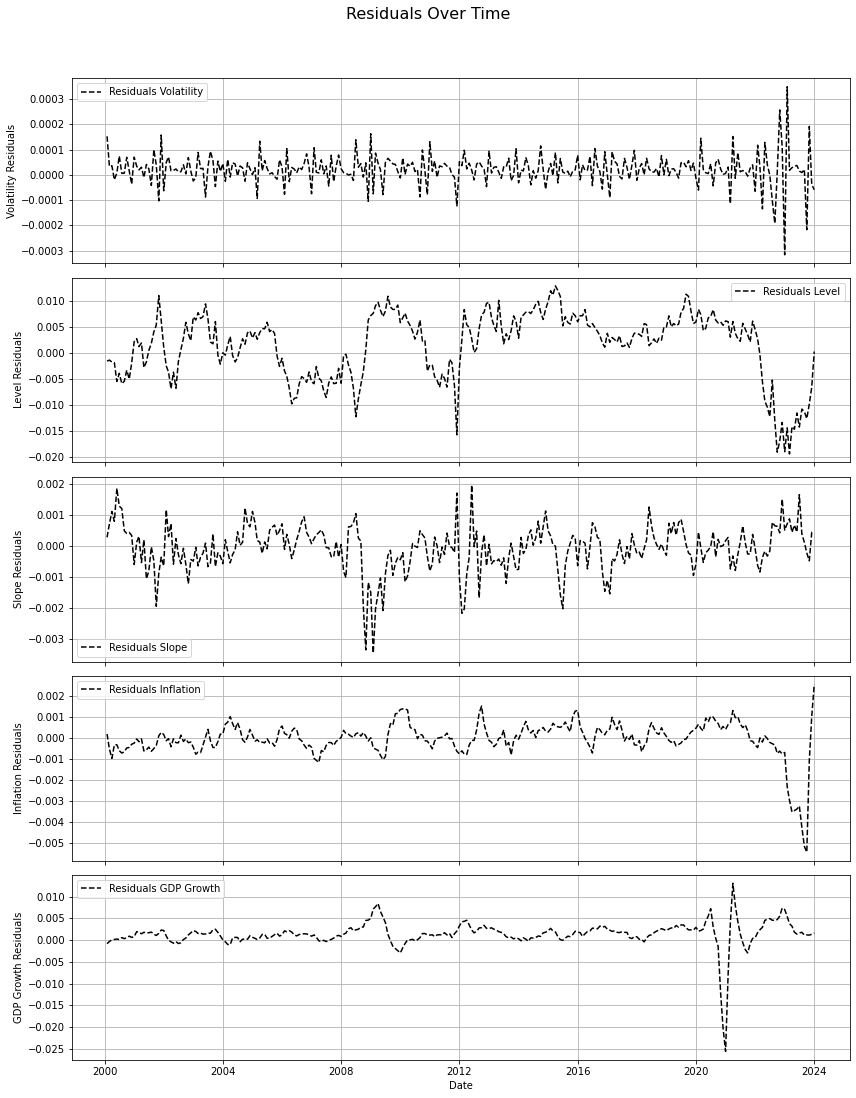

In [206]:
residuals = estimated_states - observations
fig, axes = plt.subplots(len(factors), 1, figsize=(12, 16), sharex=True)
for i, factor in enumerate(factors):
    axes[i].plot(dates_yields_truncated, residuals[:, i], color='black', ls='--', label=f'Residuals {factor}')
    axes[i].set_ylabel(factor + ' Residuals')
    axes[i].legend()
    axes[i].grid(True)

axes[-1].set_xlabel('Date')
plt.suptitle('Residuals Over Time', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Shapiro-Wilk Test for Volatility Residuals: Statistic=0.9015, p-value=0.0000
Shapiro-Wilk Test for Level Residuals: Statistic=0.9370, p-value=0.0000
Shapiro-Wilk Test for Slope Residuals: Statistic=0.9525, p-value=0.0000
Shapiro-Wilk Test for Inflation Residuals: Statistic=0.7683, p-value=0.0000
Shapiro-Wilk Test for GDP Growth Residuals: Statistic=0.6456, p-value=0.0000


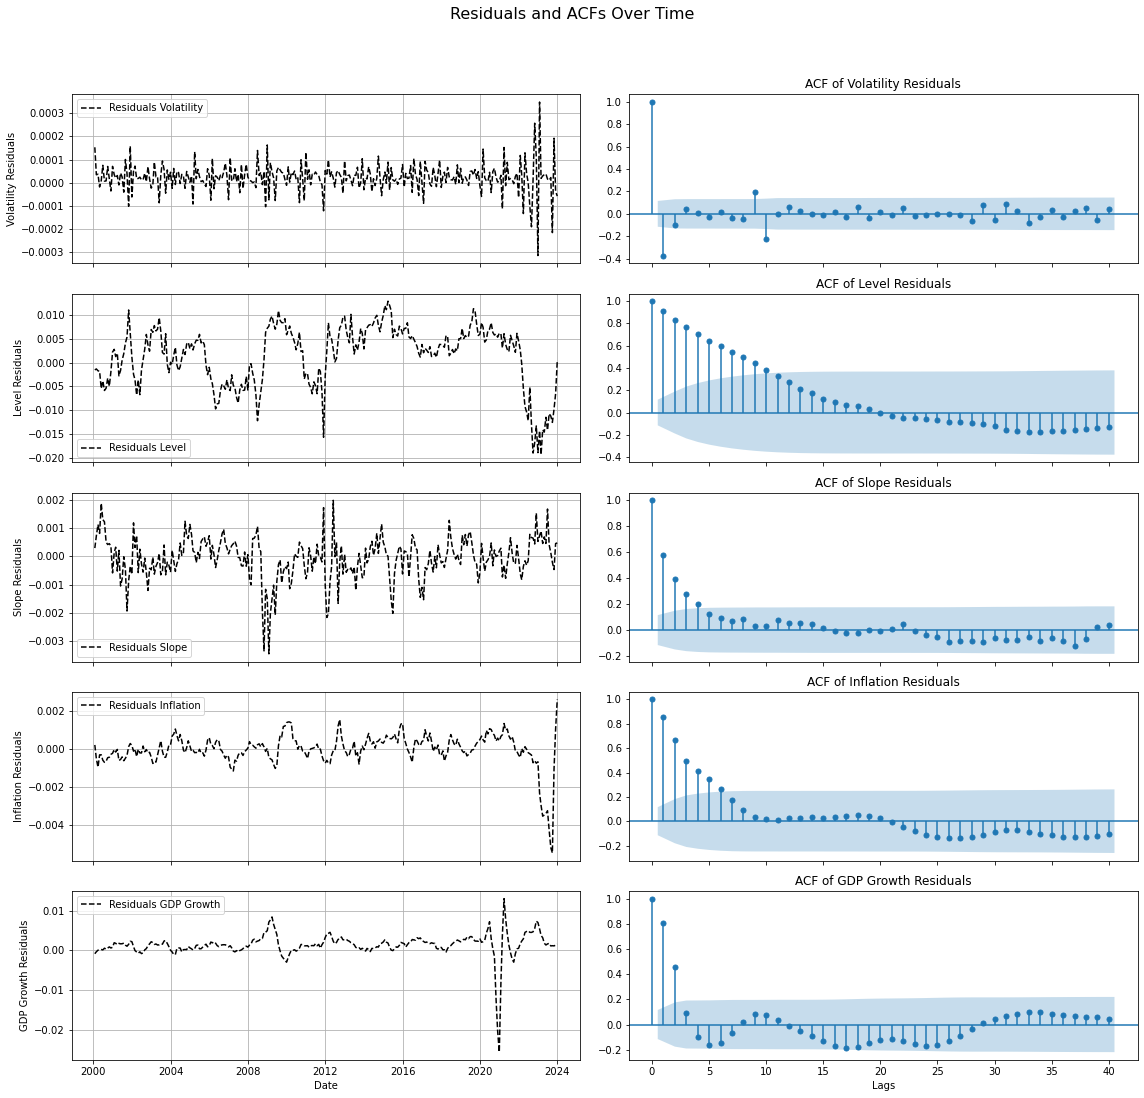

In [217]:
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import shapiro

# Store results of the Shapiro-Wilk test
shapiro_results = {}

# Create a figure with subplots, one for each factor
fig, axes = plt.subplots(len(factors), 2, figsize=(16, 16), sharex='col')

for i, factor in enumerate(factors):
    # Plot residuals in the first column, sharing the x-axis among residual plots
    axes[i, 0].plot(dates_yields_truncated, residuals[:, i], color='black', ls='--', label=f'Residuals {factor}')
    axes[i, 0].set_ylabel(factor + ' Residuals')
    axes[i, 0].legend()
    axes[i, 0].grid(True)
    
    # Plot ACF of residuals in the second column, sharing the x-axis among ACF plots
    plot_acf(residuals[:, i], ax=axes[i, 1], lags=40)
    axes[i, 1].set_title(f'ACF of {factor} Residuals')

    # Perform Shapiro-Wilk test
    shapiro_stat, p_value = shapiro(residuals[:, i])
    shapiro_results[factor] = (shapiro_stat, p_value)
    print(f'Shapiro-Wilk Test for {factor} Residuals: Statistic={shapiro_stat:.4f}, p-value={p_value:.4f}')

# Set x-axis labels for the bottom plots in each column
axes[-1, 0].set_xlabel('Date')
axes[-1, 1].set_xlabel('Lags')

plt.suptitle('Residuals and ACFs Over Time', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
aaaaaa, bbbbbbb = solve_odes(maturities, steps_per_year, K_estimated_constraint, Theta_estimated_constraint, Sigma_estimated_mean, alpha, beta, delta_0_estimated_mean, delta_1_init)
print(aaaaaa[-1], bbbbbbb[-1])
aaa, bbb = compute_BM_AM(maturities[tau-1], K_estimated_constraint, Sigma_M_estimated_mean, Theta_estimated_constraint)
print(aaa, bbb)

-0.23568365135930247 [0.72798647 5.18441455 1.52917029 1.63527587 0.45393895]
[0.13864461 0.2681669 ] [[ 0.14305003 -0.41002017 -0.45360686  2.16025037 -0.25546589]
 [ 0.01672734 -0.09807775 -0.64393569 -0.29283687  1.44648332]]


In [ ]:
#pi = aaa + bbb @ estimated_states[-1]
# plt.plot(pi, label='Estimated Inflation')
# xi = np.diag([x[0]])
# mid = np.dot(Sigma_estimated_mean, np.dot(xi, Sigma_estimated_mean))
# v_t = np.dot(bbbbbbb[-1], np.dot(mid, bbbbbbb[-1]))
# vv = v_t + np.random.normal(0, np.sqrt(np.var(EA_vol_std__.values)))
# print(vv)

In [ ]:
# # Initial observations (reshaped to be 2D as required by the UKF)
# observations__ = EA_vol_std__.values.reshape(-1, 1)

# # State transition function (Ornstein-Uhlenbeck process)
# def state_transition_function(x, dt, kappa, theta, sigma):
#     F = np.exp(-kappa * dt)
#     C = theta * (1 - F)
#     Q = sigma ** 2 * (1 - np.exp(-2 * kappa * dt)) / (2 * kappa)
#     x_new = F * x + C + np.random.normal(0, np.sqrt(Q))
#     return x_new

# # Proper measurement function based on the original implementation
# def measurement_function(x, B_tau, Sigma):
#     # Ensure x is a scalar or 1D array with one element
#     x_value = x[0] if isinstance(x, np.ndarray) else x
    
#     # Calculate volatility using the proper measurement equation
#     Xi_t = np.diag([x_value])  # Since we are dealing with a single factor, it's just x_value
#     middle = np.dot(Sigma, np.dot(Xi_t, Sigma))  # Sigma * Xi_t * Sigma'
#     V_t_ = np.dot(B_tau, np.dot(middle, B_tau))  # B_tau * (Sigma * Xi_t * Sigma') * B_tau'
    
#     # Measurement (part1) with added noise
#     part1 = V_t_ + np.random.normal(0, np.sqrt(np.var(EA_vol_std__.values)))
    
#     return np.array([part1])  # Ensure it returns a 1D array

# # Initial parameters
# kappa = 0.2611
# theta = 0.0157
# sigma = 0.0704
# X0 = np.array([EA_vol_std__.values[0]])  # Initial state
# P0 = np.eye(1) * np.var(EA_vol_std__.values)  # Initial state covariance
# R = np.eye(1) * np.var(EA_vol_std__.values)  # Measurement noise covariance
# dt = 1/12  # Time step

# # Initialize variables for the loop
# best_B_tau = None
# best_mse = float('inf')
# tolerance = 1e-6  # Convergence criterion
# max_iterations = 100  # Maximum number of iterations

# # Define a range of B_tau values to test
# B_tau_values = np.linspace(0.01, 1.0, 1000)  # Adjust range and steps as needed

# for B_tau_value in B_tau_values:
#     B_tau = np.array([B_tau_value])  # Test with the current B_tau
    
#     # Reset the UKF for each iteration
#     ukf = UKF(dim_x=1, dim_z=1, fx=lambda x, dt: state_transition_function(x, dt, kappa, theta, sigma),
#               hx=lambda x: measurement_function(x, B_tau=B_tau, Sigma=Sigma_matrix), dt=dt, points=points)

#     ukf.x = X0  # Initial state
#     ukf.P = P0  # Initial state covariance
#     ukf.R = R   # Measurement noise covariance
#     ukf.Q = sigma ** 2 * (1 - np.exp(-2 * kappa * dt)) / (2 * kappa)
#     # Run the filter over the observations
#     estimated_states = []

#     for z in observations__:
#         ukf.predict()
#         ukf.update(z)
#         estimated_states.append(ukf.x[0])

#     estimated_states = np.array(estimated_states)

#     # Calculate error metrics
#     mse = np.mean((estimated_states - EA_vol_std__.values) ** 2)
    
#     # Check for convergence
#     if mse < best_mse:
#         best_mse = mse
#         best_B_tau = B_tau_value
    
#     #print(f'B_tau: {B_tau_value}, MSE: {mse}')
    
#     # Stop if the improvement in MSE is below the tolerance level
#     if best_mse < tolerance:
#         break

# print(f'Best B_tau: {best_B_tau}, Best MSE: {best_mse}')

# # Plot the results with the best B_tau
# B_tau = np.array([best_B_tau])  # Use the best B_tau found
# ukf = UKF(dim_x=1, dim_z=1, fx=lambda x, dt: state_transition_function(x, dt, kappa, theta, sigma),
#           hx=lambda x: measurement_function(x, B_tau=B_tau, Sigma=Sigma_matrix), dt=dt, points=points)

# ukf.x = X0  # Initial state
# ukf.P = P0  # Initial state covariance
# ukf.R = R   # Measurement noise covariance
# ukf.Q = sigma ** 2 * (1 - np.exp(-2 * kappa * dt)) / (2 * kappa)
# estimated_states = []

# for z in observations__:
#     ukf.predict()
#     ukf.update(z)
#     estimated_states.append(ukf.x[0])

# estimated_states = np.array(estimated_states)

# plt.figure(figsize=(10, 6))
# plt.plot(EA_vol_std__.index, EA_vol_std__.values, label='Observed Volatility', color="blue", alpha=0.6)
# plt.plot(EA_vol_std__.index, estimated_states, label=f'Estimated Volatility (B_tau={best_B_tau})', color="black", linestyle='--')
# plt.legend()
# plt.xlabel('Date')
# plt.ylabel('Volatility')
# plt.title('Observed vs. Estimated Volatility with Optimized B_tau')
# plt.grid(True)
# plt.show()

# print(f'Final MSE: {best_mse}')